<a href="https://colab.research.google.com/github/Shaunak-Mukherjee/Nequip-reimplement-Toluene/blob/main/main_full_nequip_1000frame_toluene.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google Drive (if not already mounted)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat May 10 01:04:04 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             71W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
# Import libraries
!pip install equinox
import numpy as np
import pandas as pd
from pathlib import Path
import yaml
from tabulate import tabulate
import csv
import jax.numpy as jnp
import equinox as eqx
from jax.scipy.special import sph_harm
import numpy as np
import jax.numpy as jnp
from scipy.spatial import cKDTree
from typing import Dict
import matplotlib.pyplot as plt
import os
import numpy as np
from pathlib import Path
import pandas as pd
import numpy as np
import os
import jax
import jax.numpy as jnp
import optax
from functools import partial
from typing import Sequence
import time
from tqdm.notebook import tqdm

In [ ]:
# Define the target directory in Google Drive
target_dir = '/content/drive/MyDrive/Colab_Notebooks/Nequip_reimplement/benchmark_data/'

# Create the target directory if it doesn't exist (within Google Drive)
os.makedirs(target_dir, exist_ok=True)

# Assume your YAML output was saved to a file named 'config.yaml' (replace with your actual filename)
yaml_file_path = '/content/drive/MyDrive/Colab_Notebooks/Nequip_reimplement/configs/custom.yaml'

try:
    with open(yaml_file_path, 'r') as f:
        config = yaml.safe_load(f)
        dataset_url = config.get('dataset_url')

        if dataset_url:
            # Download the zip file using the URL from the YAML
            !wget "{dataset_url}" -O "{target_dir}toluene.zip"

            # Unzip the file
            !unzip -o "{target_dir}toluene.zip" -d "{target_dir}"
        else:
            print("Error: 'dataset_url' not found in the YAML configuration.")

except FileNotFoundError:
    print(f"Error: YAML file '{yaml_file_path}' not found.")
except Exception as e:
    print(f"An error occurred: {e}")

--2025-05-10 01:04:08--  http://quantum-machine.org/gdml/data/npz/md17_toluene.npz
Resolving quantum-machine.org (quantum-machine.org)... 130.149.80.145
Connecting to quantum-machine.org (quantum-machine.org)|130.149.80.145|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 303150886 (289M)
Saving to: ‘/content/drive/MyDrive/Colab_Notebooks/Nequip_reimplement/benchmark_data/toluene.zip’

/content/drive/MyDr 100%[===================>] 289.11M  14.0MB/s    in 24s     

2025-05-10 01:04:32 (12.1 MB/s) - ‘/content/drive/MyDrive/Colab_Notebooks/Nequip_reimplement/benchmark_data/toluene.zip’ saved [303150886/303150886]

Archive:  /content/drive/MyDrive/Colab_Notebooks/Nequip_reimplement/benchmark_data/toluene.zip
  inflating: /content/drive/MyDrive/Colab_Notebooks/Nequip_reimplement/benchmark_data/E.npy  
  inflating: /content/drive/MyDrive/Colab_Notebooks/Nequip_reimplement/benchmark_data/name.npy  
  inflating: /content/drive/MyDrive/Colab_Notebooks/Nequip_reimplement

In [ ]:
# Flatten nested dictionaries
def flatten_dict(d, parent_key='', sep='.'):
    items = []
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

# Load and flatten the YAML config
with open(yaml_file_path, 'r') as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

flat_config = flatten_dict(config)

# Convert to tabular format
table_data = list(flat_config.items())
print(tabulate(table_data, headers=["Parameter", "Value"], tablefmt=None))

Parameter                                    Value
-------------------------------------------  -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
root                                         results/toluene
run_name                                     example-run-toluene
seed                                         123
dataset_seed                                 456
append                                       True
default_dtype                                float64
model_dtype                                  float32
allow_tf32                                   True
model_builders                               ['SimpleIrrepsConfig', 'EnergyModel', 'PerSpeciesRescale', 'ForceOutput', 'RescaleEnergyEtc']
r_max                                        5.0
num_layers                      

Load and Process the NPZ File Using Dataset Logic. Load 1000 frames.

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path


# Load the full MD‑17 toluene NPZ

orig_path = Path("/content/drive/MyDrive/Colab_Notebooks/Nequip_reimplement/benchmark_data/toluene.zip")
data      = np.load(orig_path, allow_pickle=True)
print("Full dataset keys:", list(data.keys()))
print("Original frame count:", data['E'].shape[0])


# Slice down to MAX_FRAMES and save a smaller NPZ

MAX_FRAMES = 1000
n_frames   = data['E'].shape[0]

# Build a sliced dict
sliced = {}
for k, v in data.items():
    # Only slice per-frame arrays of shape (n_frames, ...)
    if isinstance(v, np.ndarray) and v.ndim >= 1 and v.shape[0] == n_frames:
        sliced[k] = v[:MAX_FRAMES]
    else:
        sliced[k] = v

# Report new shapes
print("Sliced dataset shapes:")
for k, v in sliced.items():
    if isinstance(v, np.ndarray):
        print(f"  {k}: {v.shape}")

# Save out the subset NPZ
npz_path = orig_path.parent / "md17_toluene_1000.npz"
np.savez(npz_path, **sliced)
print(f"Saved subset NPZ to {npz_path}")


# Rebuild per-atom records over only those 1000 frames

num_frames = sliced['E'].shape[0]    # == 1000
num_atoms  = sliced['R'].shape[1]    # e.g. 15

atom_props    = ['R', 'F']
atom_scalars  = ['z']
global_props  = [k for k in sliced if k not in atom_props + atom_scalars]

records = []
for frame_idx in range(num_frames):
    # collect global fields for this frame
    frame_data = {}
    for key in global_props:
        val = sliced[key]
        # if it's an array with a frame dimension, index it; else just copy
        frame_data[key] = val[frame_idx] if (isinstance(val, np.ndarray) and val.ndim > 0) else val

    R_frame = sliced['R'][frame_idx]   # shape (num_atoms, 3)
    F_frame = sliced['F'][frame_idx]   # shape (num_atoms, 3)
    z_vals  = sliced['z']              # shape (num_atoms,)

    for atom_idx in range(num_atoms):
        rec = {
            "frame":         frame_idx,
            "atom_index":    atom_idx,
            **frame_data,
            "x":              R_frame[atom_idx, 0],
            "y":              R_frame[atom_idx, 1],
            "z":              R_frame[atom_idx, 2],
            "fx":             F_frame[atom_idx, 0],
            "fy":             F_frame[atom_idx, 1],
            "fz":             F_frame[atom_idx, 2],
            "atomic_number":  int(z_vals[atom_idx]),
        }
        records.append(rec)

# For plotting and inspection
df = pd.DataFrame.from_records(records)
print("Frame count of dataset used here:", len(df['frame'].unique()))

Full dataset keys: ['E', 'name', 'F', 'theory', 'R', 'z', 'type', 'md5']
Original frame count: 442790
Sliced dataset shapes:
  E: (1000, 1)
  name: ()
  F: (1000, 15, 3)
  theory: ()
  R: (1000, 15, 3)
  z: (15,)
  type: ()
  md5: ()
Saved subset NPZ to /content/drive/MyDrive/Colab_Notebooks/Nequip_reimplement/benchmark_data/md17_toluene_1000.npz
Frame count of dataset used here: 1000


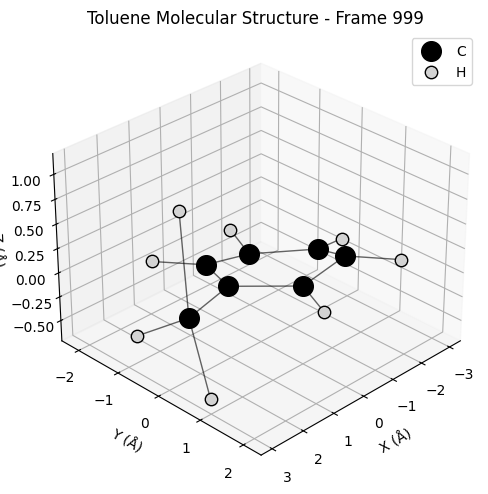

In [ ]:
# Visualize 3D structure of the molecule at a specific frame
def plot_molecular_structure(df, frame_idx=0):
    # Filter data for the specific frame
    frame_data = df[df['frame'] == frame_idx]

    # Create an atomic number to element name and color mapping
    element_map = {1: 'H', 6: 'C', 7: 'N', 8: 'O'}
    color_map = {1: 'lightgray', 6: 'black', 7: 'blue', 8: 'red'}
    size_map = {1: 80, 6: 200, 7: 200, 8: 200}

    # Create 3D plot
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(111, projection='3d')

    # Plot atoms
    for _, atom in frame_data.iterrows():
        atomic_num = atom['atomic_number']
        element = element_map.get(atomic_num, 'X')
        color = color_map.get(atomic_num, 'gray')
        size = size_map.get(atomic_num, 100)

        ax.scatter(
            atom['x'], atom['y'], atom['z'],
            color=color, s=size, edgecolors='black',
            label=f"{element}" if element not in [l.get_label() for l in ax.get_lines()] else ""
        )

    # Draw bonds (simplified approach - connect atoms that are close)
    positions = frame_data[['x', 'y', 'z']].values
    for i in range(len(positions)):
        for j in range(i+1, len(positions)):
            # Calculate distance between atoms
            dist = np.sqrt(np.sum((positions[i] - positions[j])**2))
            # If atoms are close enough, draw a bond
            if dist < 1.7:  # Typical bond length threshold in Angstroms
                ax.plot(
                    [positions[i, 0], positions[j, 0]],
                    [positions[i, 1], positions[j, 1]],
                    [positions[i, 2], positions[j, 2]],
                    'k-', linewidth=1, alpha=0.6
                )

    # Remove duplicate labels
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='best')

    # Set labels and title
    ax.set_xlabel('X (Å)')
    ax.set_ylabel('Y (Å)')
    ax.set_zlabel('Z (Å)')
    ax.set_title(f'Toluene Molecular Structure - Frame {frame_idx}')

    # Adjust view angle for better visualization
    ax.view_init(elev=30, azim=45)
    plt.tight_layout()
    plt.show()


# Plot molecular structure at frame 999
plot_molecular_structure(df, frame_idx=999)

In [ ]:
class NequIPDatasetJAX:
    def __init__(self, npz_path: str, r_max: float, max_neighbors: int = 32):
        """
        Args:
            npz_path: Path to .npz file with keys 'R', 'F', 'E', 'z'.
            r_max: cutoff radius for neighbor search.
            max_neighbors: maximum number of neighbors per atom.
        """
        data = np.load(npz_path, allow_pickle=True)
        self.R = data['R']  # (n_frames, n_atoms, 3)
        self.F = data['F']  # (n_frames, n_atoms, 3)
        self.E = data['E']  # (n_frames,)
        self.Z = data['z']  # (n_atoms,)

        self.n_frames, self.n_atoms, _ = self.R.shape
        self.r_max = r_max
        self.max_neighbors = max_neighbors

        # Precompute neighbor lists
        self.neighbor_idx = np.zeros((self.n_frames, self.n_atoms, max_neighbors), dtype=np.int32)
        self.neighbor_mask = np.zeros((self.n_frames, self.n_atoms, max_neighbors), dtype=bool)
        self.neighbor_dist = np.zeros((self.n_frames, self.n_atoms, max_neighbors), dtype=np.float32)
        for t in range(self.n_frames):
            pos = self.R[t]
            tree = cKDTree(pos)
            all_nbrs = tree.query_ball_tree(tree, self.r_max)
            for i, nbrs in enumerate(all_nbrs):
                # remove self
                nbrs = [j for j in nbrs if j != i]
                # sort by distance
                dists = np.linalg.norm(pos[nbrs] - pos[i], axis=1)
                sorted_idx = np.argsort(dists)
                nbrs = [nbrs[k] for k in sorted_idx][:max_neighbors]
                # fill arrays
                k = len(nbrs)
                self.neighbor_idx[t, i, :k] = nbrs
                self.neighbor_mask[t, i, :k] = True
                self.neighbor_dist[t, i, :k] = dists[sorted_idx[:k]]

    def __len__(self) -> int:
        return self.n_frames

    def get(self, idx: int) -> Dict[str, jnp.ndarray]:
        """
        Get single graph as JAX arrays.
        """
        pos    = jnp.array(self.R[idx])            # (n_atoms,3)
        forces = jnp.array(self.F[idx])            # (n_atoms,3)
        energy = jnp.array(self.E[idx])            # ()
        z      = jnp.array(self.Z)                 # (n_atoms,)
        nbr_idx = jnp.array(self.neighbor_idx[idx])# (n_atoms,max_neighbors)
        nbr_dist= jnp.array(self.neighbor_dist[idx])# (n_atoms,max_neighbors)
        mask    = jnp.array(self.neighbor_mask[idx])# (n_atoms,max_neighbors)
        return {
            'pos': pos,
            'z': z,
            'nbr_idx': nbr_idx,
            'nbr_dist': nbr_dist,
            'nbr_mask': mask,
            'energy': energy,
            'forces': forces
        }

    def get_batch(self, indices: np.ndarray) -> Dict[str, jnp.ndarray]:
        """
        Batch multiple graphs (assuming same number of nodes per graph).
        """
        batch = {k: jnp.stack([self.get(i)[k] for i in indices]) for k in self.get(indices[0])}
        return batch

In [ ]:
# Parse cutoff and neighbor count from flat_config
r_max_value = flat_config['r_max']
r_max = float(r_max_value)

avg_nbr = flat_config.get('avg_num_neighbors', 'auto')
if isinstance(avg_nbr, (int, float)):
    max_neighbors = int(avg_nbr)
elif isinstance(avg_nbr, str) and avg_nbr.lower() == 'auto':
    max_neighbors = 32
else:
    max_neighbors = int(avg_nbr)

print("Using r_max =", r_max, "and max_neighbors =", max_neighbors)

Using r_max = 5.0 and max_neighbors = 32


In [ ]:
npz_path

PosixPath('/content/drive/MyDrive/Colab_Notebooks/Nequip_reimplement/benchmark_data/md17_toluene_1000.npz')

In [ ]:
# Now initialize and test
ds = NequIPDatasetJAX(
    npz_path,
    r_max=r_max,
    max_neighbors=max_neighbors
)
sample = ds.get(0)
print({k: v.shape for k, v in sample.items()})


{'pos': (15, 3), 'z': (15,), 'nbr_idx': (15, 32), 'nbr_dist': (15, 32), 'nbr_mask': (15, 32), 'energy': (1,), 'forces': (15, 3)}


In [ ]:
class RealSphericalHarmonics(eqx.Module):
    """
    Manual real spherical harmonics for l_max up to 3.
    Produces components in the order:
      ℓ=0:  Y₀⁰
      ℓ=1:  Y₁⁻¹, Y₁⁰, Y₁¹
      ℓ=2:  Y₂⁻², Y₂⁻¹, Y₂⁰, Y₂¹, Y₂²
      ℓ=3:  Y₃⁻³, Y₃⁻², Y₃⁻¹, Y₃⁰, Y₃¹, Y₃², Y₃³
    """
    l_max: int
    num_harmonics: int

    def __init__(self, l_max: int):
        assert 0 <= l_max <= 3, "Supports l_max ∈ {0,1,2,3}"
        # 1 + 3 + 5 + 7 = 16 when l_max=3
        num = 1 + (3 if l_max >= 1 else 0) \
                + (5 if l_max >= 2 else 0) \
                + (7 if l_max >= 3 else 0)
        self.l_max = l_max
        self.num_harmonics = num
        super().__init__()

    def __call__(self, vecs: jnp.ndarray) -> jnp.ndarray:
        x, y, z = vecs[...,0], vecs[...,1], vecs[...,2]
        # add a tiny floor so we never divide by zero
        eps = 1e-12
        r2 = x*x + y*y + z*z + eps
        r  = jnp.sqrt(r2)
        r2 = r*r
        r3 = r2*r

        out = []
        # ℓ=0
        out.append(
            jax.lax.cond(
                self.l_max >= 0,
                lambda _: 0.5 * jnp.sqrt(1/jnp.pi) * jnp.ones_like(r),
                lambda _: jnp.zeros_like(r),
                operand=None
            )
        )
        # ℓ=1
        out.extend(
            jax.lax.cond(
                self.l_max >= 1,
                lambda _: [
                    jnp.sqrt(3/(4*jnp.pi))*(y/r),
                    jnp.sqrt(3/(4*jnp.pi))*(z/r),
                    jnp.sqrt(3/(4*jnp.pi))*(x/r),
                ],
                lambda _: [jnp.zeros_like(r)]*3,
                operand=None
            )
        )
        # ℓ=2
        out.extend(
            jax.lax.cond(
                self.l_max >= 2,
                lambda _: [
                    jnp.sqrt(15/(4*jnp.pi))*(x*y)/r2,
                    jnp.sqrt(15/(4*jnp.pi))*(y*z)/r2,
                    0.25*jnp.sqrt(5/jnp.pi)*(2*z*z - x*x - y*y)/r2,
                    jnp.sqrt(15/(4*jnp.pi))*(x*z)/r2,
                    0.5*jnp.sqrt(15/jnp.pi)*((x*x - y*y))/r2,
                ],
                lambda _: [jnp.zeros_like(r)]*5,
                operand=None
            )
        )
        # ℓ=3
        out.extend(
            jax.lax.cond(
                self.l_max >= 3,
                lambda _: [
                    jnp.sqrt(35/(16*jnp.pi)) * ((3*x*x - y*y)*y)    / r3,  # Y₃⁻³
                    jnp.sqrt(105/(4*jnp.pi)) * (x*y*z)               / r3,  # Y₃⁻²
                    jnp.sqrt(21/(8*jnp.pi)) * (y*(4*z*z - x*x - y*y))/ r3,  # Y₃⁻¹
                    jnp.sqrt(7/(4*jnp.pi))  * (z*(2*z*z - 3*x*x - 3*y*y))/ r3,  # Y₃⁰
                    jnp.sqrt(21/(8*jnp.pi)) * (x*(4*z*z - x*x - y*y)) / r3,  # Y₃¹
                    jnp.sqrt(105/(4*jnp.pi)) * ((x*x - y*y)*z)       / r3,  # Y₃²
                    jnp.sqrt(35/(16*jnp.pi)) * (x*(x*x - 3*y*y))      / r3,  # Y₃³
                ],
                lambda _: [jnp.zeros_like(r)]*7,
                operand=None
            )
        )
        return jnp.stack(out, axis=-1)


In [ ]:
# Test code
dirs = jnp.stack([
    jnp.array([1.0,0.0,0.0]),    # +x̂
    jnp.array([0.0,1.0,0.0]),    # +ŷ
    jnp.array([0.0,0.0,1.0]),    # +ẑ
    jnp.array([1.0,1.0,1.0]) / jnp.sqrt(3),
], axis=0)

sh = RealSphericalHarmonics(l_max=3)
Y = sh(dirs)

# Print and eyeball
print("Y(+x):", Y[0])
print("Y(+y):", Y[1])
print("Y(+z):", Y[2])
print("Y(diag):", Y[3])

Y(+x): [ 0.28209478  0.          0.          0.48860252  0.          0.
 -0.31539157  0.          1.0925484   0.          0.         -0.
 -0.         -0.9140916   0.          0.8344477 ]
Y(+y): [ 0.28209478  0.48860252  0.          0.          0.          0.
 -0.31539157  0.         -1.0925484  -0.8344477   0.         -0.9140916
 -0.         -0.         -0.         -0.        ]
Y(+z): [0.28209478 0.         0.48860252 0.         0.         0.
 0.63078314 0.         0.         0.         0.         0.
 1.4927053  0.         0.         0.        ]
Y(diag): [ 0.28209478  0.2820948   0.2820948   0.2820948   0.3641828   0.3641828
  0.          0.3641828   0.          0.32117912  0.5562985   0.3518341
 -0.57454264  0.3518341   0.         -0.32117912]


In [ ]:
class GaussianSmearing(eqx.Module):
    """
    Expands scalar distances into Gaussian radial basis functions.
    """
    centers: jnp.ndarray
    widths:  jnp.ndarray

    def __init__(self, start: float, stop: float, num_basis: int):
        # compute centers and widths
        centers = jnp.linspace(start, stop, num_basis)
        widths  = jnp.full((num_basis,), (stop - start) / (num_basis - 1))
        # assign as plain attributes
        self.centers = centers
        self.widths  = widths
        # register with Equinox
        super().__init__()

    def __call__(self, distances: jnp.ndarray) -> jnp.ndarray:
        d = jnp.expand_dims(distances, axis=-1)
        diff = d - self.centers
        return jnp.exp(-0.5 * (diff / self.widths) ** 2)


In [ ]:
# Test block
gs = GaussianSmearing(start=0.0, stop=3.0, num_basis=5)

distances_1d = jnp.array([0.0, 1.5, 3.0])  # shape (3,)
output_1d = gs(distances_1d)

distances_2d = jnp.array([[0.0, 1.0], [2.0, 3.0]])  # shape (2,2)
output_2d = gs(distances_2d)

print("Centers:", gs.centers)
print("Widths: ", gs.widths)
print("\nInput distances (1D):", distances_1d)
print("Output (1D) shape:", output_1d.shape)
print(output_1d)

print("\nInput distances (2D):")
print(distances_2d)
print("Output (2D) shape:", output_2d.shape)
print(output_2d)

Centers: [0.   0.75 1.5  2.25 3.  ]
Widths:  [0.75 0.75 0.75 0.75 0.75]

Input distances (1D): [0.  1.5 3. ]
Output (1D) shape: (3, 5)
[[1.0000000e+00 6.0653067e-01 1.3533528e-01 1.1108997e-02 3.3546262e-04]
 [1.3533528e-01 6.0653067e-01 1.0000000e+00 6.0653067e-01 1.3533528e-01]
 [3.3546262e-04 1.1108997e-02 1.3533528e-01 6.0653067e-01 1.0000000e+00]]

Input distances (2D):
[[0. 1.]
 [2. 3.]]
Output (2D) shape: (2, 2, 5)
[[[1.0000000e+00 6.0653067e-01 1.3533528e-01 1.1108997e-02 3.3546262e-04]
  [4.1111228e-01 9.4595945e-01 8.0073738e-01 2.4935217e-01 2.8565494e-02]]

 [[2.8565494e-02 2.4935217e-01 8.0073738e-01 9.4595945e-01 4.1111228e-01]
  [3.3546262e-04 1.1108997e-02 1.3533528e-01 6.0653067e-01 1.0000000e+00]]]


In [ ]:
class EquivariantConv(eqx.Module):
    """
    Equivariant message-passing convolution block.
    """
    radial_fn: eqx.Module    # GaussianSmearing
    sph_fn:    eqx.Module    # RealSphericalHarmonics
    W:         jnp.ndarray   # weights of shape (B, H, in_feats, out_feats)

    def __init__(
        self,
        rbf: eqx.Module,
        sph: eqx.Module,
        in_feats: int,
        out_feats: int,
        key: jax.random.PRNGKey = None
    ):
        # store sub-modules
        self.radial_fn = rbf
        self.sph_fn    = sph
        # initialize weight tensor
        B = rbf.centers.shape[0]
        H = sph.num_harmonics
        rng = jax.random.PRNGKey(0) if key is None else key
        scale = 1.0 / jnp.sqrt(in_feats * B * H)
        self.W = jax.random.normal(rng, (B, H, in_feats, out_feats)) * scale
        # register fields
        super().__init__()

    def __call__(
        self,
        feats:     jnp.ndarray,   # (n_atoms, in_feats)
        pos:       jnp.ndarray,   # (n_atoms, 3)
        nbr_idx:   jnp.ndarray,   # (n_atoms, n_nbr)
        nbr_dist:  jnp.ndarray,   # (n_atoms, n_nbr)
        nbr_mask:  jnp.ndarray    # (n_atoms, n_nbr) boolean
    ) -> jnp.ndarray:
        # gather neighbor positions
        nbr_pos   = pos[nbr_idx]               # (n_atoms, n_nbr, 3)
        vecs      = nbr_pos - pos[:, None, :]  # (n_atoms, n_nbr, 3)
        # compute radial and angular features
        phi       = self.radial_fn(nbr_dist)   # (n_atoms, n_nbr, B)
        Y         = self.sph_fn(vecs)          # (n_atoms, n_nbr, H)
        # neighbor features and mask
        nbr_feats = feats[nbr_idx]             # (n_atoms, n_nbr, in_feats)
        mask      = nbr_mask[..., None]        # (n_atoms, n_nbr, 1)

        # zero out invalid neighbors
        phi       *= mask
        Y         *= mask
        nbr_feats *= mask

        # message: sum over b,h,i  phi * Y * W * h_j
        msgs = jnp.einsum('anb,anh,bhio,ani->ano', phi, Y, self.W, nbr_feats)
        # aggregate
        return jnp.sum(msgs, axis=1)           # (n_atoms, out_feats)


In [ ]:
# Test Block
r_max     = float(flat_config['r_max'])
num_basis = int(flat_config['num_basis'])
l_max     = int(flat_config['l_max'])
hidden    = int(flat_config['num_features'])

rbf = GaussianSmearing(0.0, r_max, num_basis)
sh  = RealSphericalHarmonics(l_max=l_max)

key = jax.random.PRNGKey(123)
conv = EquivariantConv(rbf, sh, in_feats=hidden, out_feats=hidden, key=key)

# Grab one sample
sample = ds.get(0)
pos     = sample['pos']      # (n_atoms, 3)
nbr_idx = sample['nbr_idx']  # (n_atoms, n_nbr)
nbr_dist= sample['nbr_dist'] # (n_atoms, n_nbr)
nbr_mask= sample['nbr_mask'] # (n_atoms, n_nbr)

# Create a dummy feature matrix
h0 = jnp.ones((pos.shape[0], hidden), dtype=jnp.float32)

# Forward through conv
h1 = conv(h0, pos, nbr_idx, nbr_dist, nbr_mask)

print("Input feats shape:", h0.shape)
print("Output feats shape:", h1.shape)
print("Any NaNs in output?", jnp.isnan(h1).any())

Input feats shape: (15, 64)
Output feats shape: (15, 64)
Any NaNs in output? False


In [ ]:
# Define Nequip Model
class NequIPModel(eqx.Module):
    """
    NequIP model.
    """
    embedding: jnp.ndarray
    convs:     Sequence
    w1:        jnp.ndarray
    b1:        jnp.ndarray
    w2:        jnp.ndarray
    b2:        jnp.ndarray

    def __init__(self, max_z, hidden_feats, r_max, num_basis, l_max, num_layers, key):
        keys = jax.random.split(key, 3 + num_layers)
        self.embedding = (jax.random.normal(keys[0], (max_z+1, hidden_feats))
                          * jnp.sqrt(1.0/hidden_feats))
        # shared RBF/SH
        rbf = GaussianSmearing(0.0, r_max, num_basis)
        sh  = RealSphericalHarmonics(l_max=l_max)
        # conv stack
        convs = [EquivariantConv(rbf, sh,
                                 hidden_feats, hidden_feats,
                                 key=keys[1+i])
                 for i in range(num_layers)]
        self.convs = tuple(convs)
        # manual readout
        k1, k2, _ = keys[-3], keys[-2], keys[-1]
        scale = jnp.sqrt(1.0/hidden_feats)
        self.w1 = jax.random.normal(k1, (hidden_feats, hidden_feats)) * scale
        self.b1 = jnp.zeros((hidden_feats,))
        self.w2 = jax.random.normal(k2, (hidden_feats, 1)) * scale
        self.b2 = jnp.array([mean_E_pa])
        super().__init__()

    def __call__(self, pos, z, nbr_idx, nbr_dist, nbr_mask):
        h = self.embedding[z]
        for conv in self.convs:
            h = jax.nn.silu(conv(h, pos, nbr_idx, nbr_dist, nbr_mask))
        h_read = jax.nn.silu(jnp.matmul(h, self.w1) + self.b1)
        e_i    = (jnp.matmul(h_read, self.w2) + self.b2).squeeze(-1)
        return jnp.sum(e_i)

    def forces(self, pos, z, nbr_idx, nbr_dist, nbr_mask):
        energy_fn = lambda p: self(p, z, nbr_idx, nbr_dist, nbr_mask)
        return -jax.grad(energy_fn)(pos)

In [ ]:
class EquivariantConv(eqx.Module):
    """
    Equivariant message-passing convolution block.
    """
    radial_fn: eqx.Module      # GaussianSmearing
    sph_fn:    eqx.Module      # RealSphericalHarmonics
    W:         jnp.ndarray     # weights of shape (B, H, in_feats, out_feats)

    def __init__(
        self,
        rbf: eqx.Module,
        sph: eqx.Module,
        in_feats: int,
        out_feats: int,
        key=None
    ):
        # assign submodules
        self.radial_fn = rbf
        self.sph_fn    = sph
        # weight init
        B = rbf.centers.shape[0]
        H = sph.num_harmonics
        rng = jax.random.PRNGKey(0) if key is None else key
        scale = 1.0 / jnp.sqrt(in_feats * B * H)
        self.W = jax.random.normal(rng, (B, H, in_feats, out_feats)) * scale
        super().__init__()

    def __call__(
        self,
        feats: jnp.ndarray,       # (n_atoms, in_feats)
        pos:   jnp.ndarray,       # (n_atoms, 3)
        nbr_idx:  jnp.ndarray,    # (n_atoms, n_nbr)
        nbr_dist: jnp.ndarray,    # (n_atoms, n_nbr)
        nbr_mask: jnp.ndarray     # (n_atoms, n_nbr) boolean
    ) -> jnp.ndarray:
        # gather neighbor data
        nbr_pos = pos[nbr_idx]               # (n_atoms, n_nbr, 3)
        vecs = nbr_pos - pos[:, None, :]  # (n_atoms, n_nbr, 3)
        phi = self.radial_fn(nbr_dist)   # (n_atoms, n_nbr, B)
        Y = self.sph_fn(vecs)          # (n_atoms, n_nbr, H)
        nbr_feats = feats[nbr_idx]             # (n_atoms, nbr, in_feats)
        mask = nbr_mask[..., None]        # (n_atoms, n_nbr, 1)

        # apply mask
        phi = phi       * mask
        Y = Y         * mask
        nbr_feats = nbr_feats * mask

        # compute messages: sum over b,h,i  phi * Y * W * h_j
        msgs = jnp.einsum('anb,anh,bhio,ani->ano', phi, Y, self.W, nbr_feats)
        return jnp.sum(msgs, axis=1)           # (n_atoms, out_feats)

In [ ]:
# Recompute hyperparameters
max_z     = int(jnp.max(ds.Z))
hidden    = int(flat_config['num_features'])
r_max     = float(flat_config['r_max'])
num_basis = int(flat_config['num_basis'])
l_max     = int(flat_config['l_max'])
n_layers  = int(flat_config['num_layers'])
seed      = int(flat_config['seed'])
key       = jax.random.PRNGKey(seed)
learning_rate = float(flat_config['learning_rate'])
force_coeff   = float(flat_config['loss_coeffs.forces'])
batch_size    = int(flat_config['batch_size'])
num_epochs    = int(flat_config['max_epochs'])

print(f"max_z {max_z}")
print(f"hidden {hidden}")
print(f"r_max {r_max}")
print(f"num_basis {num_basis}")
print(f"l_max {l_max}")
print(f"n_layers {n_layers}")
print(f"seed {seed}")
print(f"learning_rate {learning_rate}")
print(f"force_coeff {force_coeff}")
print(f"batch_size {batch_size}")
print(f"num_epochs {num_epochs}")

max_z 6
hidden 64
r_max 5.0
num_basis 16
l_max 3
n_layers 6
seed 123
learning_rate 0.0005
force_coeff 1.0
batch_size 5
num_epochs 100000


In [ ]:
# Number of atoms per frame
n_atoms = ds.R.shape[1]

# Gather per‑atom energies for every frame
E_pa = []
for i in range(len(ds)):
    info = ds.get(i)
    E_pa.append(np.array(info['energy']) / n_atoms)
E_pa = np.stack(E_pa)          # shape (n_frames,)

mean_E_pa = float(E_pa.mean())
std_E_pa  = float(E_pa.std())
print(f"Dataset per‑atom energy: mean = {mean_E_pa:.4f}, std = {std_E_pa:.4f}")

Dataset per‑atom energy: mean = -11348.2256, std = 0.3892


In [ ]:
# instantiate Model Arch
model = NequIPModel(max_z, hidden, r_max, num_basis, l_max, n_layers, key)
model

NequIPModel(
  embedding=f32[7,64],
  convs=(
    EquivariantConv(
      radial_fn=GaussianSmearing(centers=f32[16], widths=weak_f32[16]),
      sph_fn=RealSphericalHarmonics(l_max=3, num_harmonics=16),
      W=f32[16,16,64,64]
    ),
    EquivariantConv(
      radial_fn=GaussianSmearing(centers=f32[16], widths=weak_f32[16]),
      sph_fn=RealSphericalHarmonics(l_max=3, num_harmonics=16),
      W=f32[16,16,64,64]
    ),
    EquivariantConv(
      radial_fn=GaussianSmearing(centers=f32[16], widths=weak_f32[16]),
      sph_fn=RealSphericalHarmonics(l_max=3, num_harmonics=16),
      W=f32[16,16,64,64]
    ),
    EquivariantConv(
      radial_fn=GaussianSmearing(centers=f32[16], widths=weak_f32[16]),
      sph_fn=RealSphericalHarmonics(l_max=3, num_harmonics=16),
      W=f32[16,16,64,64]
    ),
    EquivariantConv(
      radial_fn=GaussianSmearing(centers=f32[16], widths=weak_f32[16]),
      sph_fn=RealSphericalHarmonics(l_max=3, num_harmonics=16),
      W=f32[16,16,64,64]
    ),
    Equiv

In [ ]:
# Test Model
sample = ds.get(0)
pos      = sample['pos']      # (n_atoms, 3)
z        = sample['z']        # (n_atoms,)
nbr_idx  = sample['nbr_idx']  # (n_atoms, n_nbr)
nbr_dist = sample['nbr_dist'] # (n_atoms, n_nbr)
nbr_mask = sample['nbr_mask'] # (n_atoms, n_nbr)

E_pred = model(pos, z, nbr_idx, nbr_dist, nbr_mask)
print("Predicted energy shape:", E_pred.shape)        # should be ()

F_pred = model.forces(pos, z, nbr_idx, nbr_dist, nbr_mask)
print("Predicted forces shape:", F_pred.shape)        # should be (n_atoms, 3)

print("Any NaNs in energy?:", bool(jnp.isnan(E_pred)))
print("Any Infs in energy?:", bool(jnp.isinf(E_pred)))
print("Any NaNs in forces?:", bool(jnp.isnan(F_pred).any()))
print("Any Infs in forces?:", bool(jnp.isinf(F_pred).any()))


Predicted energy shape: ()
Predicted forces shape: (15, 3)
Any NaNs in energy?: False
Any Infs in energy?: False
Any NaNs in forces?: False
Any Infs in forces?: False


In [ ]:
# Pick one convolutional layer (say the first one in your model)
conv = model.convs[0]

# Grab a single frame from your dataset
sample = ds.get(0)
feats    = model.embedding[sample['z']]        # (n_atoms, hidden_feats)
pos      = sample['pos']                       # (n_atoms, 3)
nbr_idx  = sample['nbr_idx']                   # (n_atoms, n_nbr)
nbr_dist = sample['nbr_dist']                  # (n_atoms, n_nbr)
nbr_mask = sample['nbr_mask']                  # (n_atoms, n_nbr)

# Run the conv
out = conv(feats, pos, nbr_idx, nbr_dist, nbr_mask)

print("Input feats shape:", feats.shape)
print("Output feats shape:", out.shape)
print("Any NaNs in output?:", bool(jnp.isnan(out).any()))


Input feats shape: (15, 64)
Output feats shape: (15, 64)
Any NaNs in output?: False


In [ ]:
# --- Build train/validation split ---
n_val     = int(flat_config['n_val'])
idx_all   = jnp.arange(len(ds))
train_idx = idx_all[:-n_val]
val_idx   = idx_all[-n_val:]

# --- Precomputed normalization constants (from earlier) ---
# mean_E_pa, std_E_pa, std_F

# Gather all force components across your dataset
F_all = []
for i in range(len(ds)):
    frame = ds.get(i)
    F_all.append(np.array(frame['forces']))   # shape (n_atoms, 3)
F_all = np.stack(F_all)                       # shape (n_frames, n_atoms, 3)
std_F = float(F_all.std())                    # a single scalar
# print("Global force std:", std_F)

# Save your train/val split and std_F computation
checkpoint_root: str = "/content/drive/MyDrive/Colab_Notebooks/Nequip_reimplement/train/trained_custom_models_v3"

In [ ]:
def run_training(
    model,
    dataset,
    train_idx,
    val_idx,
    *,
    learning_rate: float = float(flat_config['learning_rate']),
    force_coeff:   float = float(flat_config['loss_coeffs.forces']),
    batch_size:    int   = int(flat_config['batch_size']),
    num_epochs:    int   = int(flat_config['max_epochs']),
    patience:      int   = int(flat_config['early_stopping_patiences.validation_loss']),
    min_delta:     float = float(flat_config['early_stopping_lower_bounds.LR']),
    print_every:   int   = 1,
    seed:          int   = int(flat_config['seed']),
):
    key = jax.random.PRNGKey(seed)
    os.makedirs(checkpoint_root, exist_ok=True)
    print("In training …")

    # Learning‐rate schedule & optimizer
    steps_per_epoch = max(1, train_idx.shape[0] // batch_size)
    total_steps     = steps_per_epoch * num_epochs
    lr_schedule = optax.cosine_decay_schedule(
        init_value=learning_rate,
        decay_steps=total_steps,
        alpha=0.0,  # decay all the way to zero
    )
    optimizer = optax.chain(
        optax.clip_by_global_norm(1.0),
        optax.adamw(learning_rate=lr_schedule, weight_decay=1e-5)
    )
    opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

    # Metrics containers
    train_e_losses = []
    train_f_losses = []
    val_e_losses   = []
    val_f_losses   = []
    lrs            = []
    step = 0  # will count *batches*

    # Loss fn
    def compute_loss(model, batch):
        # energy
        def single_energy(pos, z, nbr_idx, nbr_dist, nbr_mask):
            return model(pos, z, nbr_idx, nbr_dist, nbr_mask)
        E_pred = jax.vmap(single_energy)(
            batch['pos'], batch['z'],
            batch['nbr_idx'], batch['nbr_dist'], batch['nbr_mask']
        )
        # forces
        def single_force(pos, z, nbr_idx, nbr_dist, nbr_mask):
            return model.forces(pos, z, nbr_idx, nbr_dist, nbr_mask)
        F_pred = jax.vmap(single_force)(
            batch['pos'], batch['z'],
            batch['nbr_idx'], batch['nbr_dist'], batch['nbr_mask']
        )
        # per-atom‐energy MSE (standardized)
        n_atoms    = batch['pos'].shape[1]
        E_pa_pred  = (E_pred / n_atoms - mean_E_pa) / std_E_pa
        E_pa_true  = (batch['energy'] / n_atoms - mean_E_pa) / std_E_pa
        e_loss     = jnp.mean((E_pa_pred - E_pa_true)**2)
        # force MSE (standardized)
        F_s_pred   = F_pred / std_F
        F_s_true   = batch['forces'] / std_F
        f_loss     = jnp.mean((F_s_pred - F_s_true)**2)
        return e_loss + force_coeff * f_loss, (e_loss, f_loss)

    # Single‐step (jit‑compiled)
    @jax.jit
    def train_step(model, opt_state, batch, force_coeff):
        (loss, (e_loss, f_loss)), grads = eqx.filter_value_and_grad(
            compute_loss, has_aux=True
        )(model, batch)
        params = eqx.filter(model, eqx.is_array)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss, e_loss, f_loss

    # Early‑stop setup
    # os.makedirs("checkpoint_root", exist_ok=True)
    best_val = float("inf")
    wait     = 0

    # Training loop
    start_all = time.time()
    for epoch in tqdm(range(1, num_epochs + 1), desc="Epochs"):
        t0 = time.time()

        # record current LR
        lrs.append(float(lr_schedule(step)))

        # **inner loop over batches**
        perm = jax.random.permutation(key, train_idx.shape[0])
        for i in range(0, train_idx.shape[0], batch_size):
            batch_idx = train_idx[perm[i : i + batch_size]]
            batch     = dataset.get_batch(batch_idx)
            model, opt_state, loss, e_loss, f_loss = train_step(
                model, opt_state, batch, force_coeff
            )
            # ← **BUMP** the step counter *per batch* so the LR schedule advances
            step += 1

        # Log train metrics
        train_e_losses.append(float(e_loss))
        train_f_losses.append(float(f_loss))

        # Evaluate on validation set
        _, (val_e, val_f) = compute_loss(model, dataset.get_batch(val_idx))
        val_loss = float(val_e + force_coeff * val_f)
        val_e_losses.append(float(val_e))
        val_f_losses.append(float(val_f))

        # Timing & logging
        t1 = time.time()
        if epoch % print_every == 0:
            elapsed = t1 - start_all
            print(
                f"Epoch {epoch}/{num_epochs}  "
                f"time this epoch: {t1-t0:.1f}s  "
                f"elapsed: {elapsed/60:.1f}m  "
                f"train E={e_loss:.4f}, F={f_loss:.4f}  "
                f"val E={val_e:.4f}, F={val_f:.4f}"
            )

        # Early stopping & checkpoint
        if best_val - val_loss > min_delta:
            best_val = val_loss
            wait     = 0
            ckpt = f"{checkpoint_root}/best_epoch{epoch}.eqx"
            eqx.tree_serialise_leaves(ckpt, model)
            print(f" ↳ New best val_loss={best_val:.4f}, saved to {ckpt}")
        else:
            wait += 1
            if wait >= patience:
                print(f"Stopping early after {epoch} epochs (no improvement).")
                break

    # Return everything
    metrics = {
        "train_e": train_e_losses,
        "train_f": train_f_losses,
        "val_e":   val_e_losses,
        "val_f":   val_f_losses,
        "lr":      lrs,
    }
    return model, opt_state, metrics

In [ ]:
# import copy

# # Test using small dataset first
# mini_train = train_idx[:16]
# mini_val   = val_idx[:4]

# # copy the fresh model
# model_mini = copy.deepcopy(model)

# model_mini, _, metrics_mini = run_training(
#     model_mini,
#     ds,
#     mini_train,
#     mini_val,
#     num_epochs=2,          # run just 3 epochs
#     print_every=1,
#     learning_rate=1e-4,    # much lower LR
#     force_coeff=force_coeff,
#     batch_size=8,          # two batches of 8 each
# )

# print("mini train_e:", metrics_mini["train_e"])
# print("mini val_e:  ", metrics_mini["val_e"])


In [ ]:
## HARDCODE Hypoerparameters for final adjustment
learning_rate = 1e-4
# n_layers = 8
# hidden = 128
# batch_size = 16
learning_rate = learning_rate
print(f"learning_rate {learning_rate}")
print(f"force_coeff {force_coeff}")
print(f"batch_size {batch_size}")
print(f"num_epochs {num_epochs}")
print(f"seed {seed}")
print(f"num_layers: {n_layers}")
print(f"num_features: {hidden}")

learning_rate 0.0001
force_coeff 1.0
batch_size 5
num_epochs 100000
seed 123
num_layers: 6
num_features: 64


Tune Hyperparameters. Override yaml config as per model needs

In [ ]:
# Run training
print_every = 1

model, opt_state, metrics = run_training(
    model,
    ds,
    train_idx,
    val_idx,
    num_epochs=num_epochs,
    print_every= print_every,
    learning_rate=learning_rate,
    force_coeff= 1.0,
)

# After training, serialize the final model
eqx.tree_serialise_leaves(f"{checkpoint_root}/final_model.eqx", model)
print(f"Saved final model to {checkpoint_root}/final_model.eqx")

In training …


Epochs:   0%|          | 0/100000 [00:00<?, ?it/s]

Epoch 1/100000  time this epoch: 87.4s  elapsed: 1.5m  train E=0.2880, F=0.9188  val E=0.4796, F=1.0670
 ↳ New best val_loss=1.5466, saved to /content/drive/MyDrive/Colab_Notebooks/Nequip_reimplement/train/trained_custom_models_v3/best_epoch1.eqx
Epoch 2/100000  time this epoch: 28.4s  elapsed: 1.9m  train E=0.2857, F=0.9187  val E=0.4866, F=1.0670
Epoch 3/100000  time this epoch: 28.2s  elapsed: 2.4m  train E=0.2831, F=0.9184  val E=0.4961, F=1.0668
Epoch 4/100000  time this epoch: 28.0s  elapsed: 2.9m  train E=0.2827, F=0.9168  val E=0.4994, F=1.0658
Epoch 5/100000  time this epoch: 28.3s  elapsed: 3.3m  train E=0.2861, F=0.9135  val E=0.4851, F=1.0643
Epoch 6/100000  time this epoch: 28.9s  elapsed: 3.8m  train E=0.2778, F=0.9069  val E=0.5012, F=1.0595
Epoch 7/100000  time this epoch: 28.9s  elapsed: 4.3m  train E=0.2870, F=0.8967  val E=0.5332, F=1.0521
Epoch 8/100000  time this epoch: 28.2s  elapsed: 4.8m  train E=0.2960, F=0.8877  val E=0.4381, F=1.0352
 ↳ New best val_loss=1.47

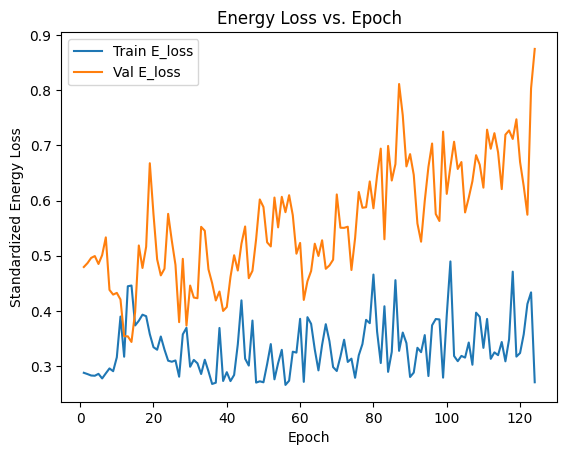

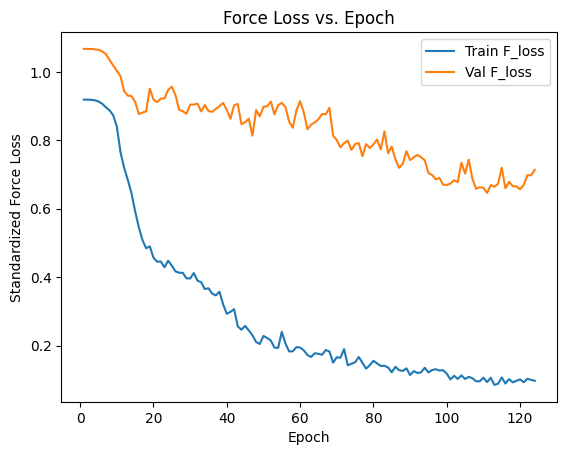

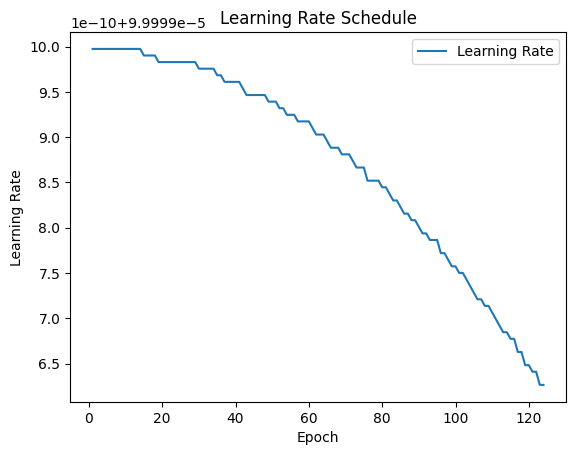

In [ ]:
# Ensure `metrics` is in scope (returned by your updated run_training)
epochs = list(range(1, len(metrics['train_e']) + 1))

# 1) Energy Loss Plot
plt.figure()
plt.plot(epochs, metrics['train_e'], label='Train E_loss')
plt.plot(epochs, metrics['val_e'],   label='Val E_loss')
plt.xlabel('Epoch')
plt.ylabel('Standardized Energy Loss')
plt.title('Energy Loss vs. Epoch')
plt.legend()
plt.show()

# 2) Force Loss Plot
plt.figure()
plt.plot(epochs, metrics['train_f'], label='Train F_loss')
plt.plot(epochs, metrics['val_f'],   label='Val F_loss')
plt.xlabel('Epoch')
plt.ylabel('Standardized Force Loss')
plt.title('Force Loss vs. Epoch')
plt.legend()
plt.show()

# 3) Learning Rate Schedule
plt.figure()
plt.plot(epochs, metrics['lr'], label='Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.legend()
plt.show()

In [ ]:
n_epochs = len(metrics['train_e'])
df = pd.DataFrame({
    'epoch':                      list(range(1, n_epochs+1)),
    'train/loss/energy_mae':      metrics['train_e'],
    'train/loss/forces_mse':      metrics['train_f'],
    'val/loss/energy_mae':        metrics['val_e'],
    'val/loss/forces_mse':        metrics['val_f'],
    'train/metric/learning_rate': metrics['lr'],
     'val/metric/learning_rate':  metrics['lr'],
})

# point here instead of flat_config paths
outdir = "/content/drive/MyDrive/Colab_Notebooks/Nequip_reimplement/train/Main_full_nequip-v3/results"
os.makedirs(outdir, exist_ok=True)

metrics_csv = os.path.join(outdir, "metrics_v2.csv")
df.to_csv(metrics_csv, index=False)
print(f"Wrote metrics to {metrics_csv}")

Wrote metrics to /content/drive/MyDrive/Colab_Notebooks/Nequip_reimplement/train/Main_full_nequip-v3/results/metrics_v2.csv


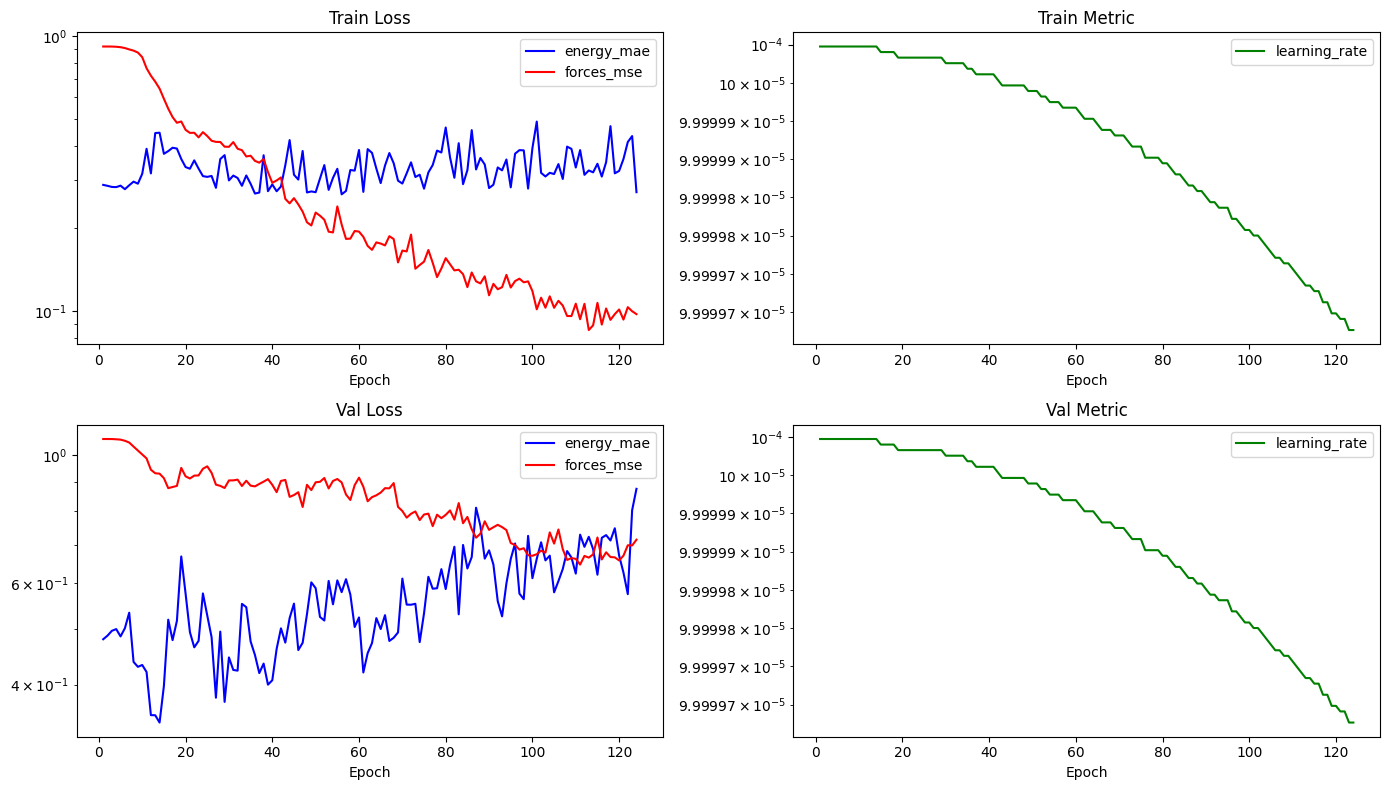

In [ ]:
plt.rcParams.update({'font.size': 10})

# Define colors_dict here
colors_dict = {
    'energy_mae': 'blue',
    'forces_mse': 'red',
    'learning_rate': 'green',
    # Add more mappings as needed
}

def get_metrics(df, group="train", type="loss"):
    if group == "train":
        cols = [c for c in df.columns if all(x in c for x in ["train", type])]
    else:
        cols = [c for c in df.columns if all(x in c for x in [group, type])]
    keep = ["epoch"] + cols
    sub = df[keep].dropna(subset=cols)
    renamed = {c: c.split("/")[-1] for c in cols}
    return sub.rename(columns=renamed), list(renamed.values())

def plot_metric_in_ax(ax, df, group="train", type="loss"):
    df_sub, names = get_metrics(df, group, type)
    lines, labels = [], []
    for name in names:
        color = colors_dict.get(name, None)
        line, = ax.plot(df_sub["epoch"], df_sub[name], color=color)
        lines.append(line)
        labels.append(name)
    ax.set_yscale("log")
    ax.set_xlabel("Epoch")
    ax.set_title(f"{group.title()} {type.title()}")
    ax.legend(lines, labels)

def plot_metrics(df):
    fig, axes = plt.subplots(2, 2, figsize=(14,8))
    plot_metric_in_ax(axes[0,0], df, "train", "loss")
    plot_metric_in_ax(axes[0,1], df, "train", "metric")
    plot_metric_in_ax(axes[1,0], df, "val",   "loss")
    plot_metric_in_ax(axes[1,1], df, "val",   "metric")
    plt.tight_layout()
    plt.show()

# load and plot
metrics_df = pd.read_csv(metrics_csv)
plot_metrics(metrics_df)

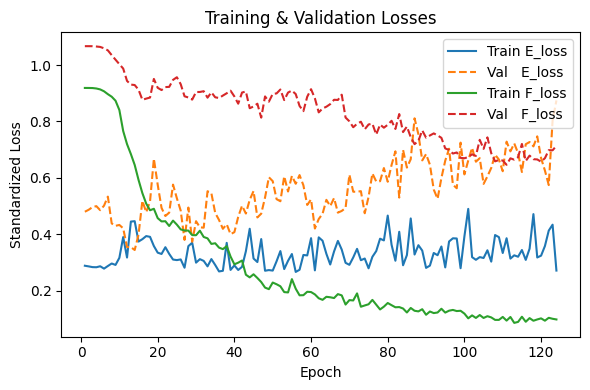

In [ ]:
n_epochs = len(metrics['train_e'])
epochs   = range(1, n_epochs + 1)

plt.figure(figsize=(6,4))
# plot energy losses
plt.plot(epochs, metrics['train_e'], label='Train E_loss', linestyle='-')
plt.plot(epochs, metrics['val_e'],   label='Val   E_loss', linestyle='--')
# plot force losses
plt.plot(epochs, metrics['train_f'], label='Train F_loss', linestyle='-')
plt.plot(epochs, metrics['val_f'],   label='Val   F_loss', linestyle='--')

plt.xlabel('Epoch')
plt.ylabel('Standardized Loss')
plt.title('Training & Validation Losses')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
